<a href="https://colab.research.google.com/github/Zshoham/FridgeVision/blob/main/FridgeVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preperation

Our goal in this project is to identify groceries in a picture of fridge
and suggest to the user what groceries he is lacking.

In this notebook we will attempt to build a model that can recognize groceries in images. We combine a few data sets in order to train our model.

The first is the COCO image data set - https://cocodataset.org/#explore wich has 10 classes of food that we will use.

Second is Freiburg Groceries Dataset - https://github.com/PhilJd/freiburg_groceries_dataset/blob/master/README.md which has 25 classes of groceries in supermarket shelfs.

Another supermarket groceries dataset - https://github.com/eg4000/SKU110K_CVPR19 contains much images with much more objects and bounding boxes.

In [1]:
!pip install py7zr

In [2]:
import requests
import os
import py7zr

FRIDGE_TRAIN = "fridge/data_fridge/data_fridge/Train"
FRIDGE_TEST = "fridge/data_fridge/data_fridge/Test"


if not os.path.isdir("fridge"):
  fridge_data = requests.get("https://drive.google.com/uc?export=download&id=1yXoDMSPodJb1xBprxplTWy9XwgJm9Mcl")
  with open("fridge.7z", 'wb') as f:
    f.write(fridge_data.content)
  
  zip = py7zr.SevenZipFile('fridge.7z', mode='r')
  zip.extractall("fridge")
  zip.close()

In [3]:
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
import json


def generate_class_map(classes):
  maps = {
      "id-name": {},
      "name-id": {}
  }
  for i in range(len(classes)):
    maps["name-id"][classes[i]] = i
    maps["id-name"][i] = classes[i]
  
  return maps

def load_dataset(data_path):
  data = []
  labels = []
  classes = os.listdir(data_path)
  cls_map = generate_class_map(classes)
  for cls in classes:
    for img_path in os.listdir(data_path + "/" + cls):
      img = Image.open(data_path + "/" + cls + "/" + img_path)
      img = img.resize((224, 224))
      data.append(np.array(img))
      labels.append(cls_map["name-id"][cls])

  data = np.array(data)
  labels = np.array(labels)
  data, labels = shuffle(data, labels)

  with open("name-id-map", 'w') as f:
    name_id_map = json.dumps(cls_map["name-id"])
    f.write(name_id_map)

  with open("id-name-map", 'w') as f:
    id_name_map = json.dumps(cls_map["id-name"])
    f.write(id_name_map)

  return data, labels, cls_map

# Data Exploration

In [ ]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

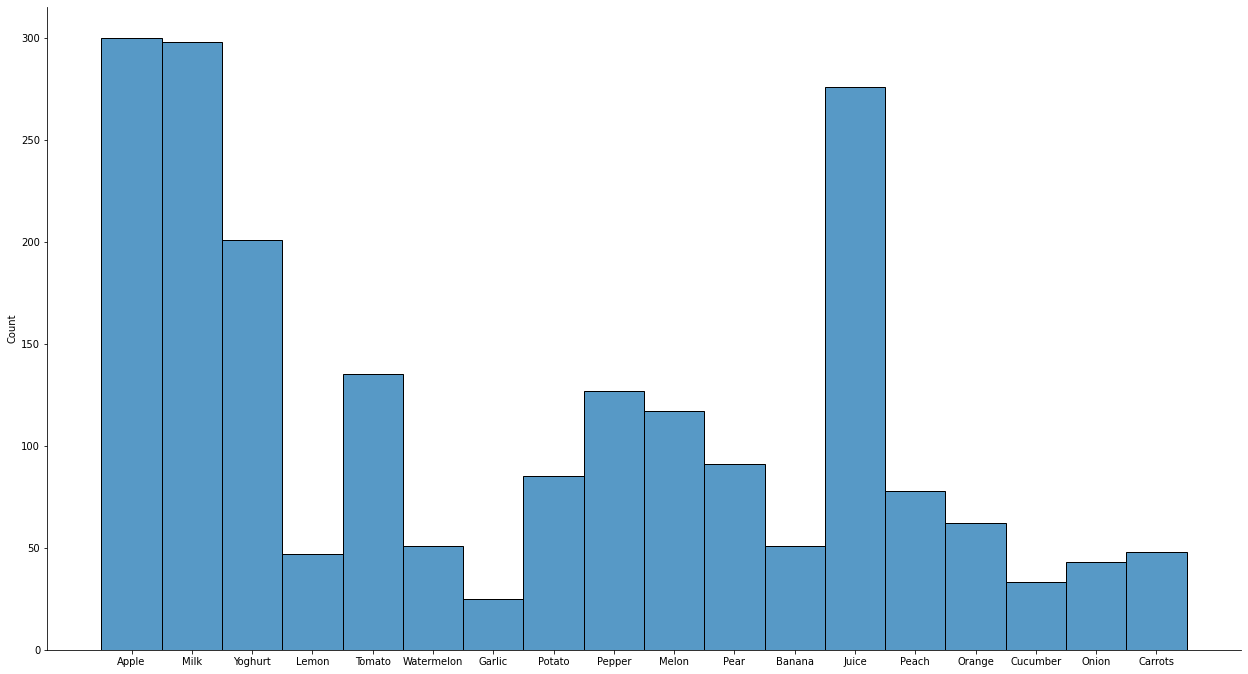

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_label_names = np.array([cls_map["id-name"][id] for id in train_labels])
test_label_names = np.array([cls_map["id-name"][id] for id in test_labels])

f = sns.displot(train_label_names)
f.fig.set_figwidth(20)
f.fig.set_figheight(10)

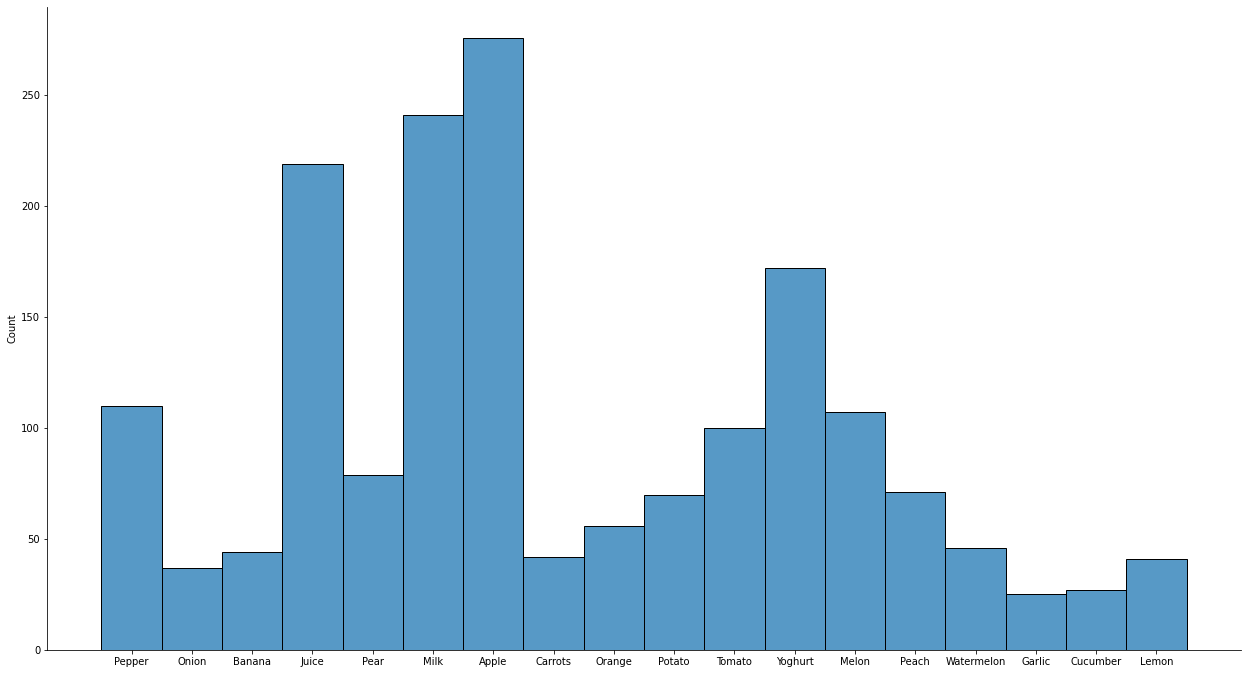

In [ ]:
f = sns.displot(test_label_names)
f.fig.set_figwidth(20)
f.fig.set_figheight(10)

As we can see the data is very imbalanced, and in general we do not have many examples of even the more popular classes, to combat this we are going to apply data augmentation selectevly, in such a way that the less examples the class has, the more augmentations it will recieve.

# Model Evaluation

In [4]:
!pip install wandb -qqq
!wandb login
import os
os.environ['WANDB_CONSOLE'] = "off"
os.environ['WANDB_SILENT'] = "true"

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


In [5]:
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

def calculate_scores(true_values, pred_values):
  acc = accuracy_score(true_values, pred_values)
  f1 = f1_score(true_values, pred_values, average='macro')

  return [
      ("accuracy", acc),
      ("f1 score", f1)
  ]

def eval_classifier(name, model_gen,
                    training_data, testing_data,
                    config):
  print("----------------------------------------")
  print(f"evaluating {name} model")
  print("----------------------------------------")

  train_data, train_labels = training_data
  test_data, test_labels = testing_data

  kf = KFold(n_splits=10)
  fold_num = 1

  for train_index, val_index in kf.split(train_data):
    x_train = train_data[train_index]
    y_train = train_labels[train_index]

    x_val = train_data[val_index]
    y_val = train_labels[val_index]

    wandb.init(
        project="FridgeVision",
        group=name,
        name=name + "-fold-" + str(fold_num),
        config=config
    )

    model = model_gen()

    model.fit(x_train, y_train,
              batch_size=config['batch_size'], epochs=config['epochs'],
              validation_data=(x_val, y_val),
              callbacks=[WandbCallback()])

    val_pred_probs = model.predict(x_val)
    val_pred = np.argmax(val_pred_probs, axis=1)
    val_scores = calculate_scores(y_val, val_pred)
  
    print("----------------------------------------")
    print(f"validation results for fold number {fold_num}:")
    for metric, score in val_scores:
      print(f"  {metric}: {score}")
    print()

    test_pred_probs = model.predict(test_data)
    test_pred = np.argmax(test_pred_probs, axis=1)
    test_scores = calculate_scores(test_labels, test_pred)

    print("----------------------------------------")
    print(f"test results for fold number {fold_num}:")
    for metric, score in test_scores:
      print(f"  {metric}: {score}")
    print()

    wandb.log({"validation " + metric: score for (metric, score) in val_scores}, commit=False)
    wandb.log({"test " + metric: score for (metric, score) in test_scores}, commit=False)
    wandb.log({"validation confusion matrix": wandb.plot.confusion_matrix(val_pred, y_val, list(cls_map["id-name"].values()))})
    wandb.log({"test confusion matrix": wandb.plot.confusion_matrix(test_pred, test_labels, list(cls_map["id-name"].values()))})

    wandb.save("id-name-map")
    wandb.save("name-id-map")
    wandb.finish()
    fold_num += 1
        

# Data Augmentation

In [6]:
import imgaug.augmenters as iaa
import imgaug as ia
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

flip = iaa.Fliplr(1.0)

rotate = iaa.Affine(rotate=(-45, 45), mode="edge")

trans = iaa.OneOf([
    iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, mode="edge"),
    iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, mode="edge")
])

noise = iaa.AdditiveGaussianNoise(scale=(0, 0.15*255), per_channel=True)

blur = iaa.GaussianBlur(sigma=(0.0, 2.0))

rc = iaa.KeepSizeByResize(iaa.Crop((160, 200), keep_size=False))



def apply_aug(data, labels, augs):
  cps = [np.copy(data) for i in range(len(augs))]
  aug_data = np.concatenate([augs[i](images=cps[i]) for i in range(len(augs))])
  aug_labels = np.concatenate([labels for i in range(len(augs))])
  return aug_data, aug_labels

def augment_by_dist(data, labels):
  classes, class_counts = np.unique(labels, return_counts=True)
  min_count = class_counts.min()
  max_count = class_counts.max()

  jmp = (max_count - min_count) / 3 
  lower_filter = min_count + jmp
  mid_filter = min_count + 2*jmp

  aug_data = data
  aug_labels = labels

  for cls in classes:
    cls_labels = labels == cls
    count_cls_labels = len(cls_labels)
    cls_labels = labels[cls_labels]
    cls_data = data[cls_labels]

    aug_cls_data_f, aug_cls_labels_f = apply_aug(cls_data, cls_labels, [rc])
    aug_data = np.concatenate((aug_data, aug_cls_data_f))
    aug_labels = np.concatenate((aug_labels, aug_cls_labels_f))

    if count_cls_labels > lower_filter:
      aug_cls_data_s, aug_cls_labels_s = apply_aug(cls_data, cls_labels, [flip, rotate, trans])
      aug_data = np.concatenate((aug_data, aug_cls_data_s))
      aug_labels = np.concatenate((aug_labels, aug_cls_labels_s))

    if count_cls_labels > mid_filter:
      aug_cls_data_t, aug_cls_labels_t = apply_aug(cls_data, cls_labels, [noise, blur])
      aug_data = np.concatenate((aug_data, aug_cls_data_t))
      aug_labels = np.concatenate((aug_labels, aug_cls_labels_t))

  return shuffle(aug_data, aug_labels)

def smote_balance(data, labels):
  s = SMOTE(random_state=42)
  o_shape = data.shape[1:]
  data = data.reshape(data.shape[0], -1)
  data, labels = s.fit_resample(data, labels)
  data = data.reshape(data.shape[0], o_shape[0], o_shape[1], o_shape[2])
  
  return shuffle(data, labels)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Naive Bayes

In [28]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [27]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(train_data, train_labels)
print("test accuracy: ", clf.score(test_data, test_labels))

test accuracy:  0.3488372093023256


In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=1000, random_state=42)
clf.fit(train_data, train_labels)
print("test accuracy: ", clf.score(test_data, test_labels))

test accuracy:  0.4288145207033466


# EfficientNetB0

In [ ]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, efficientnet

effnet_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 10,
    "epochs": 5
}

def effnet_gen():
  core = EfficientNetB0(include_top=False, input_shape=(224,224,3))

  core.trainable = False

  input = keras.Input(shape=(None, None, 3))
  x = layers.experimental.preprocessing.Resizing(224, 224)(input)

  x = core(x, training=False)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(len(cls_map["id-name"]), activation="softmax")(x)
  model = tf.keras.Model(input, outputs, name="EfficientNet")
  model.compile(optimizer=effnet_config["optimizer"], loss=effnet_config["loss"], metrics=['accuracy'])
  return model

effnet_gen().summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 18)               

## Without Augmentation

In [ ]:
train_data_aug = efficientnet.preprocess_input(train_data)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnet", effnet_gen,
                (train_data_aug, train_labels),
                (test_data_aug, test_labels),
                effnet_config)

----------------------------------------
evaluating effnet model
----------------------------------------
Epoch 1/5
187/187 [==============================] - 18s 33ms/step - loss: 2.0718 - accuracy: 0.4334 - val_loss: 0.4176 - val_accuracy: 0.8696
Epoch 2/5
187/187 [==============================] - 4s 23ms/step - loss: 0.4266 - accuracy: 0.8666 - val_loss: 0.1574 - val_accuracy: 0.9614
Epoch 3/5
187/187 [==============================] - 4s 23ms/step - loss: 0.2264 - accuracy: 0.9209 - val_loss: 0.1283 - val_accuracy: 0.9614
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1652 - accuracy: 0.9476 - val_loss: 0.1119 - val_accuracy: 0.9662
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1374 - accuracy: 0.9532 - val_loss: 0.1242 - val_accuracy: 0.9565
----------------------------------------
validation results for fold number 1:
  accuracy: 0.9565217391304348
  f1 score: 0.9243510799545283

----------------------------------------


Epoch 1/5
187/187 [==============================] - 11s 31ms/step - loss: 2.2038 - accuracy: 0.4067 - val_loss: 0.3717 - val_accuracy: 0.9179
Epoch 2/5
187/187 [==============================] - 4s 23ms/step - loss: 0.4289 - accuracy: 0.8480 - val_loss: 0.1363 - val_accuracy: 0.9517
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2499 - accuracy: 0.9141 - val_loss: 0.0746 - val_accuracy: 0.9807
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1412 - accuracy: 0.9541 - val_loss: 0.0687 - val_accuracy: 0.9710
Epoch 5/5
187/187 [==============================] - 5s 24ms/step - loss: 0.1600 - accuracy: 0.9387 - val_loss: 0.0405 - val_accuracy: 0.9903
----------------------------------------
validation results for fold number 2:
  accuracy: 0.9903381642512077
  f1 score: 0.9962232919883193

----------------------------------------
test results for fold number 2:
  accuracy: 0.9030062393647192
  f1 score: 0.8714900131899204



Epoch 1/5
187/187 [==============================] - 11s 30ms/step - loss: 2.2204 - accuracy: 0.3978 - val_loss: 0.4003 - val_accuracy: 0.9082
Epoch 2/5
187/187 [==============================] - 4s 23ms/step - loss: 0.3910 - accuracy: 0.8709 - val_loss: 0.1348 - val_accuracy: 0.9565
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2613 - accuracy: 0.9053 - val_loss: 0.0768 - val_accuracy: 0.9807
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1428 - accuracy: 0.9537 - val_loss: 0.0781 - val_accuracy: 0.9710
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1641 - accuracy: 0.9458 - val_loss: 0.0391 - val_accuracy: 0.9903
----------------------------------------
validation results for fold number 3:
  accuracy: 0.9903381642512077
  f1 score: 0.9749755620723362

----------------------------------------
test results for fold number 3:
  accuracy: 0.9047078842881452
  f1 score: 0.8774659364921359



Epoch 1/5
187/187 [==============================] - 11s 34ms/step - loss: 2.1991 - accuracy: 0.4248 - val_loss: 0.3819 - val_accuracy: 0.9130
Epoch 2/5
187/187 [==============================] - 4s 23ms/step - loss: 0.3559 - accuracy: 0.8721 - val_loss: 0.1569 - val_accuracy: 0.9420
Epoch 3/5
187/187 [==============================] - 4s 23ms/step - loss: 0.2640 - accuracy: 0.8987 - val_loss: 0.0674 - val_accuracy: 0.9807
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1674 - accuracy: 0.9450 - val_loss: 0.0578 - val_accuracy: 0.9807
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1253 - accuracy: 0.9566 - val_loss: 0.0421 - val_accuracy: 0.9952
----------------------------------------
validation results for fold number 4:
  accuracy: 0.9951690821256038
  f1 score: 0.9953546767106088

----------------------------------------
test results for fold number 4:
  accuracy: 0.9047078842881452
  f1 score: 0.8817894097656747



Epoch 1/5
187/187 [==============================] - 11s 31ms/step - loss: 2.1637 - accuracy: 0.4228 - val_loss: 0.4425 - val_accuracy: 0.8744
Epoch 2/5
187/187 [==============================] - 4s 24ms/step - loss: 0.4386 - accuracy: 0.8396 - val_loss: 0.1432 - val_accuracy: 0.9710
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2356 - accuracy: 0.9187 - val_loss: 0.0508 - val_accuracy: 0.9952
Epoch 4/5
187/187 [==============================] - 5s 24ms/step - loss: 0.1832 - accuracy: 0.9370 - val_loss: 0.0435 - val_accuracy: 1.0000
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1259 - accuracy: 0.9578 - val_loss: 0.0352 - val_accuracy: 0.9952
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9951690821256038
  f1 score: 0.9792592592592592

----------------------------------------
test results for fold number 5:
  accuracy: 0.9018718094157686
  f1 score: 0.8779207347127196



Epoch 1/5
187/187 [==============================] - 11s 31ms/step - loss: 2.2057 - accuracy: 0.3941 - val_loss: 0.3671 - val_accuracy: 0.9517
Epoch 2/5
187/187 [==============================] - 5s 24ms/step - loss: 0.4262 - accuracy: 0.8648 - val_loss: 0.1035 - val_accuracy: 0.9758
Epoch 3/5
187/187 [==============================] - 5s 24ms/step - loss: 0.2515 - accuracy: 0.9160 - val_loss: 0.0661 - val_accuracy: 0.9855
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1812 - accuracy: 0.9353 - val_loss: 0.0557 - val_accuracy: 0.9903
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1327 - accuracy: 0.9542 - val_loss: 0.0277 - val_accuracy: 0.9903
----------------------------------------
validation results for fold number 6:
  accuracy: 0.9903381642512077
  f1 score: 0.989960608261262

----------------------------------------
test results for fold number 6:
  accuracy: 0.8910947249007374
  f1 score: 0.8571627618239338



Epoch 1/5
187/187 [==============================] - 10s 31ms/step - loss: 2.1027 - accuracy: 0.4301 - val_loss: 0.3786 - val_accuracy: 0.9227
Epoch 2/5
187/187 [==============================] - 5s 27ms/step - loss: 0.4138 - accuracy: 0.8481 - val_loss: 0.1300 - val_accuracy: 0.9662
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2513 - accuracy: 0.9159 - val_loss: 0.0930 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1762 - accuracy: 0.9345 - val_loss: 0.0479 - val_accuracy: 0.9903
Epoch 5/5
187/187 [==============================] - 5s 24ms/step - loss: 0.1248 - accuracy: 0.9648 - val_loss: 0.0524 - val_accuracy: 0.9855
----------------------------------------
validation results for fold number 7:
  accuracy: 0.9855072463768116
  f1 score: 0.9813591893780573

----------------------------------------
test results for fold number 7:
  accuracy: 0.9047078842881452
  f1 score: 0.8673258436349519



Epoch 1/5
187/187 [==============================] - 11s 35ms/step - loss: 2.0089 - accuracy: 0.4521 - val_loss: 0.4131 - val_accuracy: 0.9227
Epoch 2/5
187/187 [==============================] - 4s 24ms/step - loss: 0.4184 - accuracy: 0.8506 - val_loss: 0.1883 - val_accuracy: 0.9469
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2372 - accuracy: 0.9252 - val_loss: 0.1150 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1541 - accuracy: 0.9490 - val_loss: 0.1194 - val_accuracy: 0.9565
Epoch 5/5
187/187 [==============================] - 5s 24ms/step - loss: 0.1429 - accuracy: 0.9507 - val_loss: 0.0955 - val_accuracy: 0.9758
----------------------------------------
validation results for fold number 8:
  accuracy: 0.9758454106280193
  f1 score: 0.8965200918402889

----------------------------------------
test results for fold number 8:
  accuracy: 0.9030062393647192
  f1 score: 0.8767172153415408



Epoch 1/5
187/187 [==============================] - 11s 36ms/step - loss: 2.0995 - accuracy: 0.4170 - val_loss: 0.3345 - val_accuracy: 0.9272
Epoch 2/5
187/187 [==============================] - 4s 24ms/step - loss: 0.4214 - accuracy: 0.8573 - val_loss: 0.1149 - val_accuracy: 0.9709
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2170 - accuracy: 0.9185 - val_loss: 0.0591 - val_accuracy: 0.9806
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1627 - accuracy: 0.9403 - val_loss: 0.0565 - val_accuracy: 0.9854
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1365 - accuracy: 0.9499 - val_loss: 0.0632 - val_accuracy: 0.9806
----------------------------------------
validation results for fold number 9:
  accuracy: 0.9805825242718447
  f1 score: 0.9795178677531619

----------------------------------------
test results for fold number 9:
  accuracy: 0.9052750992626205
  f1 score: 0.8846386417039507



Epoch 1/5
187/187 [==============================] - 11s 32ms/step - loss: 2.2066 - accuracy: 0.4295 - val_loss: 0.3659 - val_accuracy: 0.9320
Epoch 2/5
187/187 [==============================] - 5s 24ms/step - loss: 0.4352 - accuracy: 0.8543 - val_loss: 0.1092 - val_accuracy: 0.9757
Epoch 3/5
187/187 [==============================] - 4s 24ms/step - loss: 0.2635 - accuracy: 0.9017 - val_loss: 0.0904 - val_accuracy: 0.9806
Epoch 4/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1880 - accuracy: 0.9401 - val_loss: 0.0744 - val_accuracy: 0.9757
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 0.1320 - accuracy: 0.9528 - val_loss: 0.0516 - val_accuracy: 0.9854
----------------------------------------
validation results for fold number 10:
  accuracy: 0.9854368932038835
  f1 score: 0.9705400830599897

----------------------------------------
test results for fold number 10:
  accuracy: 0.8888258650028361
  f1 score: 0.8708155848867243



## With Augmentation

In [ ]:
train_data_aug, train_labels_aug = augment_by_dist(train_data, train_labels)

In [ ]:
effnet_aug_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 100,
    "epochs": 5
}

train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnet-aug", effnet_gen,
                (train_data_aug, train_labels_aug),
                (test_data_aug, test_labels),
                effnet_aug_config)

----------------------------------------
evaluating effnet-aug model
----------------------------------------
Epoch 1/5
131/131 [==============================] - 32s 200ms/step - loss: 1.5484 - accuracy: 0.6226 - val_loss: 0.6389 - val_accuracy: 0.8881
Epoch 2/5
131/131 [==============================] - 24s 185ms/step - loss: 0.4577 - accuracy: 0.8639 - val_loss: 0.3782 - val_accuracy: 0.9095
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3747 - accuracy: 0.8877 - val_loss: 0.2890 - val_accuracy: 0.9309
Epoch 4/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3206 - accuracy: 0.9066 - val_loss: 0.2635 - val_accuracy: 0.9302
Epoch 5/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3140 - accuracy: 0.9089 - val_loss: 0.2512 - val_accuracy: 0.9330
----------------------------------------
validation results for fold number 1:
  accuracy: 0.9330110497237569
  f1 score: 0.9235821754317843

----------------------------

Epoch 1/5
131/131 [==============================] - 31s 194ms/step - loss: 1.5899 - accuracy: 0.5991 - val_loss: 0.6821 - val_accuracy: 0.8543
Epoch 2/5
131/131 [==============================] - 24s 185ms/step - loss: 0.4691 - accuracy: 0.8604 - val_loss: 0.4002 - val_accuracy: 0.8978
Epoch 3/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3684 - accuracy: 0.8881 - val_loss: 0.3176 - val_accuracy: 0.9130
Epoch 4/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3141 - accuracy: 0.9089 - val_loss: 0.2906 - val_accuracy: 0.9171
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.2924 - accuracy: 0.9155 - val_loss: 0.2798 - val_accuracy: 0.9144
----------------------------------------
validation results for fold number 2:
  accuracy: 0.914364640883978
  f1 score: 0.9157006442777303

----------------------------------------
test results for fold number 2:
  accuracy: 0.8723766307430516
  f1 score: 0.845239222050109



Epoch 1/5
131/131 [==============================] - 31s 195ms/step - loss: 1.4516 - accuracy: 0.6234 - val_loss: 0.6378 - val_accuracy: 0.8874
Epoch 2/5
131/131 [==============================] - 24s 184ms/step - loss: 0.4508 - accuracy: 0.8647 - val_loss: 0.3945 - val_accuracy: 0.8992
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3624 - accuracy: 0.8917 - val_loss: 0.3086 - val_accuracy: 0.9157
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3466 - accuracy: 0.8954 - val_loss: 0.2761 - val_accuracy: 0.9227
Epoch 5/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3191 - accuracy: 0.9068 - val_loss: 0.2582 - val_accuracy: 0.9289
----------------------------------------
validation results for fold number 3:
  accuracy: 0.9288674033149171
  f1 score: 0.921856270004191

----------------------------------------
test results for fold number 3:
  accuracy: 0.8701077708451503
  f1 score: 0.843617409428624



Epoch 1/5
131/131 [==============================] - 31s 194ms/step - loss: 1.5119 - accuracy: 0.6200 - val_loss: 0.6478 - val_accuracy: 0.8916
Epoch 2/5
131/131 [==============================] - 24s 185ms/step - loss: 0.4367 - accuracy: 0.8680 - val_loss: 0.3768 - val_accuracy: 0.9206
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3727 - accuracy: 0.8896 - val_loss: 0.2846 - val_accuracy: 0.9323
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3357 - accuracy: 0.8992 - val_loss: 0.2528 - val_accuracy: 0.9337
Epoch 5/5
131/131 [==============================] - 24s 186ms/step - loss: 0.3050 - accuracy: 0.9091 - val_loss: 0.2458 - val_accuracy: 0.9365
----------------------------------------
validation results for fold number 4:
  accuracy: 0.93646408839779
  f1 score: 0.9357795477637479

----------------------------------------
test results for fold number 4:
  accuracy: 0.8757799205899036
  f1 score: 0.8331973210054842



Epoch 1/5
131/131 [==============================] - 31s 200ms/step - loss: 1.5059 - accuracy: 0.6177 - val_loss: 0.6597 - val_accuracy: 0.8785
Epoch 2/5
131/131 [==============================] - 24s 184ms/step - loss: 0.4445 - accuracy: 0.8674 - val_loss: 0.3913 - val_accuracy: 0.9164
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3687 - accuracy: 0.8880 - val_loss: 0.2964 - val_accuracy: 0.9199
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3386 - accuracy: 0.8989 - val_loss: 0.2504 - val_accuracy: 0.9365
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3259 - accuracy: 0.9058 - val_loss: 0.2347 - val_accuracy: 0.9372
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9371546961325967
  f1 score: 0.9319144385473529

----------------------------------------
test results for fold number 5:
  accuracy: 0.8672716959727736
  f1 score: 0.8449747112010734



Epoch 1/5
131/131 [==============================] - 31s 200ms/step - loss: 1.3837 - accuracy: 0.6546 - val_loss: 0.6695 - val_accuracy: 0.8626
Epoch 2/5
131/131 [==============================] - 24s 184ms/step - loss: 0.4592 - accuracy: 0.8667 - val_loss: 0.3947 - val_accuracy: 0.9075
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3568 - accuracy: 0.8918 - val_loss: 0.3096 - val_accuracy: 0.9192
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3351 - accuracy: 0.8989 - val_loss: 0.2930 - val_accuracy: 0.9171
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3064 - accuracy: 0.9098 - val_loss: 0.2581 - val_accuracy: 0.9199
----------------------------------------
validation results for fold number 6:
  accuracy: 0.919889502762431
  f1 score: 0.9075519019251543

----------------------------------------
test results for fold number 6:
  accuracy: 0.869540555870675
  f1 score: 0.8412347581236302



Epoch 1/5
131/131 [==============================] - 31s 198ms/step - loss: 1.5005 - accuracy: 0.6182 - val_loss: 0.6282 - val_accuracy: 0.8763
Epoch 2/5
131/131 [==============================] - 24s 185ms/step - loss: 0.4634 - accuracy: 0.8632 - val_loss: 0.3512 - val_accuracy: 0.9178
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3692 - accuracy: 0.8908 - val_loss: 0.2623 - val_accuracy: 0.9419
Epoch 4/5
131/131 [==============================] - 25s 191ms/step - loss: 0.3225 - accuracy: 0.9052 - val_loss: 0.2337 - val_accuracy: 0.9371
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3283 - accuracy: 0.9055 - val_loss: 0.2212 - val_accuracy: 0.9385
----------------------------------------
validation results for fold number 7:
  accuracy: 0.9384934346924672
  f1 score: 0.9288134984198124

----------------------------------------
test results for fold number 7:
  accuracy: 0.8655700510493477
  f1 score: 0.8348687161172283



Epoch 1/5
131/131 [==============================] - 30s 193ms/step - loss: 1.4929 - accuracy: 0.6290 - val_loss: 0.6610 - val_accuracy: 0.8756
Epoch 2/5
131/131 [==============================] - 24s 185ms/step - loss: 0.4459 - accuracy: 0.8669 - val_loss: 0.3679 - val_accuracy: 0.9115
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3706 - accuracy: 0.8893 - val_loss: 0.2810 - val_accuracy: 0.9309
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3400 - accuracy: 0.8971 - val_loss: 0.2590 - val_accuracy: 0.9261
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3097 - accuracy: 0.9096 - val_loss: 0.2386 - val_accuracy: 0.9350
----------------------------------------
validation results for fold number 8:
  accuracy: 0.93503800967519
  f1 score: 0.9298622000807638

----------------------------------------
test results for fold number 8:
  accuracy: 0.871242200794101
  f1 score: 0.8449423757040802



Epoch 1/5
131/131 [==============================] - 30s 194ms/step - loss: 1.3846 - accuracy: 0.6382 - val_loss: 0.6612 - val_accuracy: 0.8818
Epoch 2/5
131/131 [==============================] - 24s 184ms/step - loss: 0.4400 - accuracy: 0.8665 - val_loss: 0.3713 - val_accuracy: 0.9129
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3785 - accuracy: 0.8894 - val_loss: 0.2994 - val_accuracy: 0.9212
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3362 - accuracy: 0.9030 - val_loss: 0.2662 - val_accuracy: 0.9343
Epoch 5/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3144 - accuracy: 0.9080 - val_loss: 0.2546 - val_accuracy: 0.9274
----------------------------------------
validation results for fold number 9:
  accuracy: 0.9274360746371804
  f1 score: 0.9146676202272466

----------------------------------------
test results for fold number 9:
  accuracy: 0.8689733408961997
  f1 score: 0.8370843400872057



Epoch 1/5
131/131 [==============================] - 31s 194ms/step - loss: 1.4306 - accuracy: 0.6383 - val_loss: 0.6414 - val_accuracy: 0.8763
Epoch 2/5
131/131 [==============================] - 24s 184ms/step - loss: 0.4523 - accuracy: 0.8646 - val_loss: 0.3738 - val_accuracy: 0.9136
Epoch 3/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3583 - accuracy: 0.8960 - val_loss: 0.2958 - val_accuracy: 0.9281
Epoch 4/5
131/131 [==============================] - 24s 185ms/step - loss: 0.3249 - accuracy: 0.9039 - val_loss: 0.2542 - val_accuracy: 0.9343
Epoch 5/5
131/131 [==============================] - 24s 186ms/step - loss: 0.2948 - accuracy: 0.9128 - val_loss: 0.2528 - val_accuracy: 0.9357
----------------------------------------
validation results for fold number 10:
  accuracy: 0.9357290946786455
  f1 score: 0.9332817744013284

----------------------------------------
test results for fold number 10:
  accuracy: 0.869540555870675
  f1 score: 0.8336705109422385



## SMOTE

In [ ]:
train_data_aug, train_labels_aug = smote_balance(train_data, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
effnet_smote_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 50 ,
    "epochs": 5
}

train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnet-smote", effnet_gen,
                (train_data_aug, train_labels_aug),
                (test_data_aug, test_labels),
                effnet_smote_config)

----------------------------------------
evaluating effnet-smote model
----------------------------------------
Epoch 1/5
98/98 [==============================] - 17s 119ms/step - loss: 2.1102 - accuracy: 0.4241 - val_loss: 0.6593 - val_accuracy: 0.8963
Epoch 2/5
98/98 [==============================] - 9s 94ms/step - loss: 0.4042 - accuracy: 0.8722 - val_loss: 0.3047 - val_accuracy: 0.9407
Epoch 3/5
98/98 [==============================] - 9s 94ms/step - loss: 0.2458 - accuracy: 0.9176 - val_loss: 0.1715 - val_accuracy: 0.9667
Epoch 4/5
98/98 [==============================] - 9s 95ms/step - loss: 0.1769 - accuracy: 0.9405 - val_loss: 0.1192 - val_accuracy: 0.9667
Epoch 5/5
98/98 [==============================] - 9s 95ms/step - loss: 0.1396 - accuracy: 0.9500 - val_loss: 0.0966 - val_accuracy: 0.9722
----------------------------------------
validation results for fold number 1:
  accuracy: 0.9722222222222222
  f1 score: 0.9718954197772128

----------------------------------------
tes

Epoch 1/5
98/98 [==============================] - 15s 108ms/step - loss: 2.1960 - accuracy: 0.4206 - val_loss: 0.6352 - val_accuracy: 0.9037
Epoch 2/5
98/98 [==============================] - 9s 95ms/step - loss: 0.4273 - accuracy: 0.8564 - val_loss: 0.2622 - val_accuracy: 0.9611
Epoch 3/5
98/98 [==============================] - 9s 95ms/step - loss: 0.2457 - accuracy: 0.9238 - val_loss: 0.1397 - val_accuracy: 0.9759
Epoch 4/5
98/98 [==============================] - 9s 95ms/step - loss: 0.1711 - accuracy: 0.9451 - val_loss: 0.0955 - val_accuracy: 0.9796
Epoch 5/5
98/98 [==============================] - 9s 95ms/step - loss: 0.1481 - accuracy: 0.9499 - val_loss: 0.0761 - val_accuracy: 0.9852
----------------------------------------
validation results for fold number 2:
  accuracy: 0.9851851851851852
  f1 score: 0.9845038833713744

----------------------------------------
test results for fold number 2:
  accuracy: 0.88712422007941
  f1 score: 0.8623909036804895



Epoch 1/5
98/98 [==============================] - 15s 109ms/step - loss: 2.2361 - accuracy: 0.4118 - val_loss: 0.7029 - val_accuracy: 0.8741
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4651 - accuracy: 0.8468 - val_loss: 0.2998 - val_accuracy: 0.9481
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2818 - accuracy: 0.9099 - val_loss: 0.1605 - val_accuracy: 0.9667
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1889 - accuracy: 0.9355 - val_loss: 0.1071 - val_accuracy: 0.9778
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1501 - accuracy: 0.9483 - val_loss: 0.0769 - val_accuracy: 0.9815
----------------------------------------
validation results for fold number 3:
  accuracy: 0.9814814814814815
  f1 score: 0.9808392028626147

----------------------------------------
test results for fold number 3:
  accuracy: 0.8905275099262621
  f1 score: 0.8645249250476147



Epoch 1/5
98/98 [==============================] - 16s 109ms/step - loss: 2.2324 - accuracy: 0.4005 - val_loss: 0.6400 - val_accuracy: 0.9130
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4243 - accuracy: 0.8618 - val_loss: 0.2835 - val_accuracy: 0.9407
Epoch 3/5
98/98 [==============================] - 9s 95ms/step - loss: 0.2402 - accuracy: 0.9238 - val_loss: 0.1589 - val_accuracy: 0.9611
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1978 - accuracy: 0.9297 - val_loss: 0.1066 - val_accuracy: 0.9685
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1396 - accuracy: 0.9533 - val_loss: 0.0903 - val_accuracy: 0.9704
----------------------------------------
validation results for fold number 4:
  accuracy: 0.9703703703703703
  f1 score: 0.9722539983052394

----------------------------------------
test results for fold number 4:
  accuracy: 0.8893930799773114
  f1 score: 0.8605610794042557



Epoch 1/5
98/98 [==============================] - 15s 109ms/step - loss: 2.3035 - accuracy: 0.3997 - val_loss: 0.6693 - val_accuracy: 0.8852
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4135 - accuracy: 0.8568 - val_loss: 0.2848 - val_accuracy: 0.9519
Epoch 3/5
98/98 [==============================] - 10s 104ms/step - loss: 0.2415 - accuracy: 0.9172 - val_loss: 0.1664 - val_accuracy: 0.9630
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1719 - accuracy: 0.9392 - val_loss: 0.1213 - val_accuracy: 0.9685
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1491 - accuracy: 0.9496 - val_loss: 0.1018 - val_accuracy: 0.9722
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9722222222222222
  f1 score: 0.9712922933979071

----------------------------------------
test results for fold number 5:
  accuracy: 0.8814520703346569
  f1 score: 0.8574818575748031



Epoch 1/5
98/98 [==============================] - 15s 110ms/step - loss: 2.1820 - accuracy: 0.4135 - val_loss: 0.6368 - val_accuracy: 0.9241
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4084 - accuracy: 0.8632 - val_loss: 0.2715 - val_accuracy: 0.9537
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2500 - accuracy: 0.9232 - val_loss: 0.1468 - val_accuracy: 0.9722
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1638 - accuracy: 0.9440 - val_loss: 0.1090 - val_accuracy: 0.9667
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1474 - accuracy: 0.9514 - val_loss: 0.0843 - val_accuracy: 0.9778
----------------------------------------
validation results for fold number 6:
  accuracy: 0.9777777777777777
  f1 score: 0.976456890288497

----------------------------------------
test results for fold number 6:
  accuracy: 0.8848553601815088
  f1 score: 0.85095004791584



Epoch 1/5
98/98 [==============================] - 15s 110ms/step - loss: 2.2032 - accuracy: 0.4100 - val_loss: 0.6523 - val_accuracy: 0.8907
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4221 - accuracy: 0.8563 - val_loss: 0.2700 - val_accuracy: 0.9556
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2507 - accuracy: 0.9140 - val_loss: 0.1482 - val_accuracy: 0.9722
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1793 - accuracy: 0.9383 - val_loss: 0.0969 - val_accuracy: 0.9759
Epoch 5/5
98/98 [==============================] - 9s 97ms/step - loss: 0.1542 - accuracy: 0.9507 - val_loss: 0.0758 - val_accuracy: 0.9852
----------------------------------------
validation results for fold number 7:
  accuracy: 0.9851851851851852
  f1 score: 0.9858502573322251

----------------------------------------
test results for fold number 7:
  accuracy: 0.8888258650028361
  f1 score: 0.8554397651372632



Epoch 1/5
98/98 [==============================] - 15s 109ms/step - loss: 2.2161 - accuracy: 0.4063 - val_loss: 0.7188 - val_accuracy: 0.8463
Epoch 2/5
98/98 [==============================] - 11s 107ms/step - loss: 0.4039 - accuracy: 0.8659 - val_loss: 0.3246 - val_accuracy: 0.9315
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2348 - accuracy: 0.9170 - val_loss: 0.1938 - val_accuracy: 0.9519
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1759 - accuracy: 0.9402 - val_loss: 0.1323 - val_accuracy: 0.9593
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1479 - accuracy: 0.9516 - val_loss: 0.1068 - val_accuracy: 0.9648
----------------------------------------
validation results for fold number 8:
  accuracy: 0.9648148148148148
  f1 score: 0.9648137374728761

----------------------------------------
test results for fold number 8:
  accuracy: 0.8820192853091322
  f1 score: 0.8515613320058795



Epoch 1/5
98/98 [==============================] - 16s 109ms/step - loss: 2.1198 - accuracy: 0.4177 - val_loss: 0.6568 - val_accuracy: 0.9037
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4267 - accuracy: 0.8540 - val_loss: 0.2768 - val_accuracy: 0.9537
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2424 - accuracy: 0.9230 - val_loss: 0.1629 - val_accuracy: 0.9648
Epoch 4/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1717 - accuracy: 0.9457 - val_loss: 0.1119 - val_accuracy: 0.9741
Epoch 5/5
98/98 [==============================] - 9s 96ms/step - loss: 0.1363 - accuracy: 0.9579 - val_loss: 0.0832 - val_accuracy: 0.9778
----------------------------------------
validation results for fold number 9:
  accuracy: 0.9777777777777777
  f1 score: 0.9770445420646152

----------------------------------------
test results for fold number 9:
  accuracy: 0.8814520703346569
  f1 score: 0.8522566442081471



Epoch 1/5
98/98 [==============================] - 17s 110ms/step - loss: 2.2224 - accuracy: 0.4096 - val_loss: 0.6659 - val_accuracy: 0.9000
Epoch 2/5
98/98 [==============================] - 9s 96ms/step - loss: 0.4431 - accuracy: 0.8527 - val_loss: 0.2784 - val_accuracy: 0.9611
Epoch 3/5
98/98 [==============================] - 9s 96ms/step - loss: 0.2434 - accuracy: 0.9222 - val_loss: 0.1392 - val_accuracy: 0.9796
Epoch 4/5
98/98 [==============================] - 9s 97ms/step - loss: 0.1973 - accuracy: 0.9352 - val_loss: 0.0897 - val_accuracy: 0.9778
Epoch 5/5
98/98 [==============================] - 9s 97ms/step - loss: 0.1509 - accuracy: 0.9501 - val_loss: 0.0640 - val_accuracy: 0.9870
----------------------------------------
validation results for fold number 10:
  accuracy: 0.987037037037037
  f1 score: 0.985990489207135

----------------------------------------
test results for fold number 10:
  accuracy: 0.893930799773114
  f1 score: 0.8592247883686273



# EfficientNetB3

In [7]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import EfficientNetB3, efficientnet

effnetb3_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b3',
    "batch_size": 10,
    "epochs": 5
}

def effnetb3_gen():
  core = EfficientNetB3(include_top=False, input_shape=(224,224,3))

  core.trainable = False

  input = keras.Input(shape=(None, None, 3))
  x = layers.experimental.preprocessing.Resizing(224, 224)(input)

  x = core(x, training=False)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(len(cls_map["id-name"]), activation="softmax")(x)
  model = tf.keras.Model(input, outputs, name="EfficientNetB3")
  model.compile(optimizer=effnetb3_config["optimizer"], loss=effnetb3_config["loss"], metrics=['accuracy'])
  return model

effnetb3_gen().summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "EfficientNetB3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_____________________________________________________

## Without Augmentation

In [ ]:
train_data_aug = efficientnet.preprocess_input(train_data)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnetb3", effnetb3_gen,
                (train_data_aug, train_labels),
                (test_data_aug, test_labels),
                effnetb3_config)

----------------------------------------
evaluating effnetb3 model
----------------------------------------
Epoch 1/5
187/187 [==============================] - 20s 59ms/step - loss: 1.8726 - accuracy: 0.5079 - val_loss: 0.3944 - val_accuracy: 0.9082
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3285 - accuracy: 0.8894 - val_loss: 0.1345 - val_accuracy: 0.9469
Epoch 3/5
187/187 [==============================] - 8s 43ms/step - loss: 0.2095 - accuracy: 0.9355 - val_loss: 0.1186 - val_accuracy: 0.9614
Epoch 4/5
187/187 [==============================] - 8s 44ms/step - loss: 0.1605 - accuracy: 0.9438 - val_loss: 0.1010 - val_accuracy: 0.9662
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1173 - accuracy: 0.9559 - val_loss: 0.1219 - val_accuracy: 0.9614
----------------------------------------
validation results for fold number 1:
  accuracy: 0.961352657004831
  f1 score: 0.9589111560807605

----------------------------------------

Epoch 1/5
187/187 [==============================] - 19s 55ms/step - loss: 1.9244 - accuracy: 0.4869 - val_loss: 0.3567 - val_accuracy: 0.9324
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3665 - accuracy: 0.8796 - val_loss: 0.1163 - val_accuracy: 0.9710
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2217 - accuracy: 0.9270 - val_loss: 0.0633 - val_accuracy: 0.9855
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1322 - accuracy: 0.9560 - val_loss: 0.0450 - val_accuracy: 0.9903
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.0930 - accuracy: 0.9637 - val_loss: 0.0469 - val_accuracy: 0.9855
----------------------------------------
validation results for fold number 2:
  accuracy: 0.9855072463768116
  f1 score: 0.9650863566038331

----------------------------------------
test results for fold number 2:
  accuracy: 0.9013045944412933
  f1 score: 0.8787377787055418



Epoch 1/5
187/187 [==============================] - 17s 55ms/step - loss: 2.0649 - accuracy: 0.4601 - val_loss: 0.3527 - val_accuracy: 0.9275
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3271 - accuracy: 0.8776 - val_loss: 0.1259 - val_accuracy: 0.9614
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2238 - accuracy: 0.9163 - val_loss: 0.0884 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1372 - accuracy: 0.9562 - val_loss: 0.0793 - val_accuracy: 0.9710
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1086 - accuracy: 0.9633 - val_loss: 0.0509 - val_accuracy: 0.9807
----------------------------------------
validation results for fold number 3:
  accuracy: 0.9806763285024155
  f1 score: 0.978443551333577

----------------------------------------
test results for fold number 3:
  accuracy: 0.9052750992626205
  f1 score: 0.8846110740214166



Epoch 1/5
187/187 [==============================] - 18s 55ms/step - loss: 1.8875 - accuracy: 0.4936 - val_loss: 0.3613 - val_accuracy: 0.9082
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3645 - accuracy: 0.8812 - val_loss: 0.1652 - val_accuracy: 0.9420
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2058 - accuracy: 0.9249 - val_loss: 0.1644 - val_accuracy: 0.9565
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1656 - accuracy: 0.9422 - val_loss: 0.1366 - val_accuracy: 0.9565
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1284 - accuracy: 0.9537 - val_loss: 0.0930 - val_accuracy: 0.9614
----------------------------------------
validation results for fold number 4:
  accuracy: 0.961352657004831
  f1 score: 0.9577798348606517

----------------------------------------
test results for fold number 4:
  accuracy: 0.9024390243902439
  f1 score: 0.8774656508499045



Epoch 1/5
187/187 [==============================] - 18s 55ms/step - loss: 1.8098 - accuracy: 0.5039 - val_loss: 0.3772 - val_accuracy: 0.8841
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3169 - accuracy: 0.9020 - val_loss: 0.1422 - val_accuracy: 0.9710
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1924 - accuracy: 0.9337 - val_loss: 0.0642 - val_accuracy: 0.9758
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1500 - accuracy: 0.9510 - val_loss: 0.0600 - val_accuracy: 0.9855
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1361 - accuracy: 0.9571 - val_loss: 0.0651 - val_accuracy: 0.9758
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9758454106280193
  f1 score: 0.9807506793284426

----------------------------------------
test results for fold number 5:
  accuracy: 0.8967668746454907
  f1 score: 0.8651266531428441



Epoch 1/5
187/187 [==============================] - 19s 54ms/step - loss: 2.0267 - accuracy: 0.4602 - val_loss: 0.4124 - val_accuracy: 0.8986
Epoch 2/5
187/187 [==============================] - 8s 43ms/step - loss: 0.3196 - accuracy: 0.8922 - val_loss: 0.1522 - val_accuracy: 0.9565
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2086 - accuracy: 0.9294 - val_loss: 0.1022 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1649 - accuracy: 0.9452 - val_loss: 0.0875 - val_accuracy: 0.9710
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1275 - accuracy: 0.9490 - val_loss: 0.0866 - val_accuracy: 0.9662
----------------------------------------
validation results for fold number 6:
  accuracy: 0.966183574879227
  f1 score: 0.9691895696386766

----------------------------------------
test results for fold number 6:
  accuracy: 0.8927963698241633
  f1 score: 0.8601555894381486



Epoch 1/5
187/187 [==============================] - 18s 55ms/step - loss: 1.8081 - accuracy: 0.4917 - val_loss: 0.3459 - val_accuracy: 0.9469
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3741 - accuracy: 0.8760 - val_loss: 0.1683 - val_accuracy: 0.9469
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2254 - accuracy: 0.9236 - val_loss: 0.1123 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1954 - accuracy: 0.9286 - val_loss: 0.1506 - val_accuracy: 0.9565
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.0993 - accuracy: 0.9671 - val_loss: 0.1632 - val_accuracy: 0.9614
----------------------------------------
validation results for fold number 7:
  accuracy: 0.961352657004831
  f1 score: 0.946839191258429

----------------------------------------
test results for fold number 7:
  accuracy: 0.9081111741349972
  f1 score: 0.8867366199958674



Epoch 1/5
187/187 [==============================] - 18s 55ms/step - loss: 1.9375 - accuracy: 0.4759 - val_loss: 0.3723 - val_accuracy: 0.9227
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.4338 - accuracy: 0.8510 - val_loss: 0.1355 - val_accuracy: 0.9565
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2444 - accuracy: 0.9082 - val_loss: 0.0941 - val_accuracy: 0.9710
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1501 - accuracy: 0.9394 - val_loss: 0.0846 - val_accuracy: 0.9662
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1187 - accuracy: 0.9604 - val_loss: 0.0910 - val_accuracy: 0.9662
----------------------------------------
validation results for fold number 8:
  accuracy: 0.966183574879227
  f1 score: 0.9689444731774997

----------------------------------------
test results for fold number 8:
  accuracy: 0.8950652297220647
  f1 score: 0.8742904089858654



Epoch 1/5
187/187 [==============================] - 20s 58ms/step - loss: 2.0166 - accuracy: 0.4595 - val_loss: 0.3397 - val_accuracy: 0.9223
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3482 - accuracy: 0.8643 - val_loss: 0.1273 - val_accuracy: 0.9515
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2298 - accuracy: 0.9203 - val_loss: 0.0620 - val_accuracy: 0.9854
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1801 - accuracy: 0.9422 - val_loss: 0.1098 - val_accuracy: 0.9660
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1188 - accuracy: 0.9677 - val_loss: 0.0506 - val_accuracy: 0.9806
----------------------------------------
validation results for fold number 9:
  accuracy: 0.9805825242718447
  f1 score: 0.9254574378591316

----------------------------------------
test results for fold number 9:
  accuracy: 0.9052750992626205
  f1 score: 0.8846951450889736



Epoch 1/5
187/187 [==============================] - 18s 54ms/step - loss: 1.8921 - accuracy: 0.4882 - val_loss: 0.3836 - val_accuracy: 0.8981
Epoch 2/5
187/187 [==============================] - 8s 44ms/step - loss: 0.3574 - accuracy: 0.8733 - val_loss: 0.1840 - val_accuracy: 0.9369
Epoch 3/5
187/187 [==============================] - 8s 45ms/step - loss: 0.2051 - accuracy: 0.9402 - val_loss: 0.1167 - val_accuracy: 0.9612
Epoch 4/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1661 - accuracy: 0.9479 - val_loss: 0.0941 - val_accuracy: 0.9612
Epoch 5/5
187/187 [==============================] - 8s 45ms/step - loss: 0.1066 - accuracy: 0.9608 - val_loss: 0.0793 - val_accuracy: 0.9757
----------------------------------------
validation results for fold number 10:
  accuracy: 0.9757281553398058
  f1 score: 0.9817210351666164

----------------------------------------
test results for fold number 10:
  accuracy: 0.9137833238797505
  f1 score: 0.9008767070281459



## With Augmentation

In [11]:
train_data_aug, train_labels_aug = augment_by_dist(train_data, train_labels)

In [12]:
effnetb3_aug_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b3',
    "batch_size": 200,
    "epochs": 5
}

train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnetb3-aug", effnetb3_gen,
                (train_data_aug, train_labels_aug),
                (test_data, test_labels),
                effnetb3_aug_config)

----------------------------------------
evaluating effnetb3-aug model
----------------------------------------
Epoch 1/5
66/66 [==============================] - 61s 790ms/step - loss: 1.7005 - accuracy: 0.5752 - val_loss: 0.9287 - val_accuracy: 0.8267
Epoch 2/5
66/66 [==============================] - 47s 717ms/step - loss: 0.5091 - accuracy: 0.8518 - val_loss: 0.6203 - val_accuracy: 0.8847
Epoch 3/5
66/66 [==============================] - 47s 719ms/step - loss: 0.4112 - accuracy: 0.8772 - val_loss: 0.4562 - val_accuracy: 0.8902
Epoch 4/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3868 - accuracy: 0.8832 - val_loss: 0.3595 - val_accuracy: 0.9019
Epoch 5/5
66/66 [==============================] - 47s 718ms/step - loss: 0.3769 - accuracy: 0.8867 - val_loss: 0.3132 - val_accuracy: 0.8950
----------------------------------------
validation results for fold number 1:
  accuracy: 0.8950276243093923
  f1 score: 0.9055316146254495

------------------------------------

Epoch 1/5
66/66 [==============================] - 58s 763ms/step - loss: 1.8427 - accuracy: 0.5355 - val_loss: 0.9587 - val_accuracy: 0.8184
Epoch 2/5
66/66 [==============================] - 47s 715ms/step - loss: 0.5393 - accuracy: 0.8427 - val_loss: 0.6372 - val_accuracy: 0.8798
Epoch 3/5
66/66 [==============================] - 47s 719ms/step - loss: 0.4295 - accuracy: 0.8705 - val_loss: 0.4569 - val_accuracy: 0.9019
Epoch 4/5
66/66 [==============================] - 47s 714ms/step - loss: 0.4060 - accuracy: 0.8781 - val_loss: 0.3662 - val_accuracy: 0.9075
Epoch 5/5
66/66 [==============================] - 47s 714ms/step - loss: 0.3743 - accuracy: 0.8887 - val_loss: 0.3264 - val_accuracy: 0.8978
----------------------------------------
validation results for fold number 2:
  accuracy: 0.8977900552486188
  f1 score: 0.8928118179423827

----------------------------------------
test results for fold number 2:
  accuracy: 0.8689733408961997
  f1 score: 0.8415019281524816



Epoch 1/5
66/66 [==============================] - 58s 762ms/step - loss: 1.7379 - accuracy: 0.5650 - val_loss: 0.9435 - val_accuracy: 0.8329
Epoch 2/5
66/66 [==============================] - 47s 714ms/step - loss: 0.5258 - accuracy: 0.8506 - val_loss: 0.6253 - val_accuracy: 0.8612
Epoch 3/5
66/66 [==============================] - 47s 718ms/step - loss: 0.4318 - accuracy: 0.8699 - val_loss: 0.4484 - val_accuracy: 0.8916
Epoch 4/5
66/66 [==============================] - 47s 714ms/step - loss: 0.3904 - accuracy: 0.8817 - val_loss: 0.3548 - val_accuracy: 0.8999
Epoch 5/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3699 - accuracy: 0.8874 - val_loss: 0.3061 - val_accuracy: 0.8992
----------------------------------------
validation results for fold number 3:
  accuracy: 0.899171270718232
  f1 score: 0.9041871546450236

----------------------------------------
test results for fold number 3:
  accuracy: 0.871242200794101
  f1 score: 0.8409846549864669



Epoch 1/5
66/66 [==============================] - 58s 761ms/step - loss: 1.8333 - accuracy: 0.5566 - val_loss: 0.9627 - val_accuracy: 0.8267
Epoch 2/5
66/66 [==============================] - 47s 715ms/step - loss: 0.5196 - accuracy: 0.8516 - val_loss: 0.6306 - val_accuracy: 0.8854
Epoch 3/5
66/66 [==============================] - 47s 721ms/step - loss: 0.4446 - accuracy: 0.8667 - val_loss: 0.4454 - val_accuracy: 0.8992
Epoch 4/5
66/66 [==============================] - 47s 715ms/step - loss: 0.3659 - accuracy: 0.8879 - val_loss: 0.3517 - val_accuracy: 0.9047
Epoch 5/5
66/66 [==============================] - 47s 717ms/step - loss: 0.3583 - accuracy: 0.8903 - val_loss: 0.3039 - val_accuracy: 0.9033
----------------------------------------
validation results for fold number 4:
  accuracy: 0.9033149171270718
  f1 score: 0.8964939047105855

----------------------------------------
test results for fold number 4:
  accuracy: 0.8610323312535451
  f1 score: 0.8280198384430021



Epoch 1/5
66/66 [==============================] - 58s 763ms/step - loss: 1.9304 - accuracy: 0.5374 - val_loss: 0.9211 - val_accuracy: 0.8425
Epoch 2/5
66/66 [==============================] - 47s 714ms/step - loss: 0.5233 - accuracy: 0.8503 - val_loss: 0.6031 - val_accuracy: 0.8902
Epoch 3/5
66/66 [==============================] - 48s 723ms/step - loss: 0.4224 - accuracy: 0.8741 - val_loss: 0.4383 - val_accuracy: 0.8985
Epoch 4/5
66/66 [==============================] - 47s 715ms/step - loss: 0.3856 - accuracy: 0.8852 - val_loss: 0.3431 - val_accuracy: 0.8992
Epoch 5/5
66/66 [==============================] - 47s 714ms/step - loss: 0.3491 - accuracy: 0.8960 - val_loss: 0.2947 - val_accuracy: 0.9088
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9088397790055248
  f1 score: 0.9137918478347444

----------------------------------------
test results for fold number 5:
  accuracy: 0.8644356211003971
  f1 score: 0.843630949104697



Epoch 1/5
66/66 [==============================] - 58s 762ms/step - loss: 1.7715 - accuracy: 0.5640 - val_loss: 0.9209 - val_accuracy: 0.8211
Epoch 2/5
66/66 [==============================] - 47s 712ms/step - loss: 0.5398 - accuracy: 0.8430 - val_loss: 0.6153 - val_accuracy: 0.8902
Epoch 3/5
66/66 [==============================] - 48s 726ms/step - loss: 0.4343 - accuracy: 0.8725 - val_loss: 0.4536 - val_accuracy: 0.8881
Epoch 4/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3811 - accuracy: 0.8847 - val_loss: 0.3670 - val_accuracy: 0.9123
Epoch 5/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3649 - accuracy: 0.8895 - val_loss: 0.3182 - val_accuracy: 0.9033
----------------------------------------
validation results for fold number 6:
  accuracy: 0.9033149171270718
  f1 score: 0.8966375402638442

----------------------------------------
test results for fold number 6:
  accuracy: 0.8587634713556438
  f1 score: 0.822306184197469



Epoch 1/5
66/66 [==============================] - 59s 776ms/step - loss: 1.8897 - accuracy: 0.5446 - val_loss: 0.9886 - val_accuracy: 0.8169
Epoch 2/5
66/66 [==============================] - 47s 713ms/step - loss: 0.5113 - accuracy: 0.8484 - val_loss: 0.6822 - val_accuracy: 0.8632
Epoch 3/5
66/66 [==============================] - 47s 718ms/step - loss: 0.4044 - accuracy: 0.8774 - val_loss: 0.5029 - val_accuracy: 0.8791
Epoch 4/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3786 - accuracy: 0.8845 - val_loss: 0.4118 - val_accuracy: 0.8818
Epoch 5/5
66/66 [==============================] - 47s 718ms/step - loss: 0.3493 - accuracy: 0.8935 - val_loss: 0.3591 - val_accuracy: 0.8901
----------------------------------------
validation results for fold number 7:
  accuracy: 0.8901174844505875
  f1 score: 0.8925734938416858

----------------------------------------
test results for fold number 7:
  accuracy: 0.8559273964832672
  f1 score: 0.8326236810767305



Epoch 1/5
66/66 [==============================] - 58s 760ms/step - loss: 1.7967 - accuracy: 0.5546 - val_loss: 0.9968 - val_accuracy: 0.8093
Epoch 2/5
66/66 [==============================] - 47s 714ms/step - loss: 0.5390 - accuracy: 0.8458 - val_loss: 0.6649 - val_accuracy: 0.8818
Epoch 3/5
66/66 [==============================] - 47s 720ms/step - loss: 0.4236 - accuracy: 0.8724 - val_loss: 0.4777 - val_accuracy: 0.8991
Epoch 4/5
66/66 [==============================] - 47s 715ms/step - loss: 0.3817 - accuracy: 0.8867 - val_loss: 0.3774 - val_accuracy: 0.8970
Epoch 5/5
66/66 [==============================] - 47s 717ms/step - loss: 0.3628 - accuracy: 0.8920 - val_loss: 0.3222 - val_accuracy: 0.9088
----------------------------------------
validation results for fold number 8:
  accuracy: 0.9087767795438839
  f1 score: 0.9029292560012165

----------------------------------------
test results for fold number 8:
  accuracy: 0.8718094157685763
  f1 score: 0.846277030040969



Epoch 1/5
66/66 [==============================] - 58s 764ms/step - loss: 1.8033 - accuracy: 0.5554 - val_loss: 0.9816 - val_accuracy: 0.7913
Epoch 2/5
66/66 [==============================] - 47s 714ms/step - loss: 0.5487 - accuracy: 0.8429 - val_loss: 0.6698 - val_accuracy: 0.8542
Epoch 3/5
66/66 [==============================] - 48s 721ms/step - loss: 0.4251 - accuracy: 0.8790 - val_loss: 0.4795 - val_accuracy: 0.8894
Epoch 4/5
66/66 [==============================] - 47s 715ms/step - loss: 0.3816 - accuracy: 0.8834 - val_loss: 0.3878 - val_accuracy: 0.8922
Epoch 5/5
66/66 [==============================] - 48s 721ms/step - loss: 0.3645 - accuracy: 0.8918 - val_loss: 0.3295 - val_accuracy: 0.9074
----------------------------------------
validation results for fold number 9:
  accuracy: 0.907394609536973
  f1 score: 0.8977230124262761

----------------------------------------
test results for fold number 9:
  accuracy: 0.8593306863301191
  f1 score: 0.8233479732898126



Epoch 1/5
66/66 [==============================] - 58s 763ms/step - loss: 1.7932 - accuracy: 0.5558 - val_loss: 0.9336 - val_accuracy: 0.8245
Epoch 2/5
66/66 [==============================] - 47s 714ms/step - loss: 0.5203 - accuracy: 0.8481 - val_loss: 0.6024 - val_accuracy: 0.8846
Epoch 3/5
66/66 [==============================] - 48s 722ms/step - loss: 0.4403 - accuracy: 0.8698 - val_loss: 0.4263 - val_accuracy: 0.9060
Epoch 4/5
66/66 [==============================] - 47s 717ms/step - loss: 0.3861 - accuracy: 0.8835 - val_loss: 0.3382 - val_accuracy: 0.9060
Epoch 5/5
66/66 [==============================] - 47s 716ms/step - loss: 0.3737 - accuracy: 0.8855 - val_loss: 0.2867 - val_accuracy: 0.9178
----------------------------------------
validation results for fold number 10:
  accuracy: 0.9177608845888044
  f1 score: 0.9198245515142632

----------------------------------------
test results for fold number 10:
  accuracy: 0.8752127056154283
  f1 score: 0.8505999947111884



## SMOTE

In [9]:
train_data_aug, train_labels_aug = smote_balance(train_data, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [10]:
effnetb3_smote_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b3',
    "batch_size": 50,
    "epochs": 5
}

train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data_aug = efficientnet.preprocess_input(test_data)
eval_classifier("effnetb3-smote", effnetb3_gen,
                (train_data_aug, train_labels_aug),
                (test_data, test_labels),
                effnetb3_smote_config)

----------------------------------------
evaluating effnetb3-smote model
----------------------------------------
Epoch 1/5
98/98 [==============================] - 35s 208ms/step - loss: 1.9807 - accuracy: 0.4708 - val_loss: 0.6444 - val_accuracy: 0.8963
Epoch 2/5
98/98 [==============================] - 18s 180ms/step - loss: 0.3461 - accuracy: 0.8842 - val_loss: 0.2784 - val_accuracy: 0.9370
Epoch 3/5
98/98 [==============================] - 18s 184ms/step - loss: 0.1943 - accuracy: 0.9408 - val_loss: 0.1707 - val_accuracy: 0.9500
Epoch 4/5
98/98 [==============================] - 18s 187ms/step - loss: 0.1366 - accuracy: 0.9540 - val_loss: 0.1222 - val_accuracy: 0.9611
Epoch 5/5
98/98 [==============================] - 18s 184ms/step - loss: 0.1059 - accuracy: 0.9638 - val_loss: 0.1077 - val_accuracy: 0.9611
----------------------------------------
validation results for fold number 1:
  accuracy: 0.9611111111111111
  f1 score: 0.9615674274172865

----------------------------------

Epoch 1/5
98/98 [==============================] - 27s 201ms/step - loss: 1.9181 - accuracy: 0.4719 - val_loss: 0.6087 - val_accuracy: 0.9204
Epoch 2/5
98/98 [==============================] - 18s 189ms/step - loss: 0.3266 - accuracy: 0.8923 - val_loss: 0.2629 - val_accuracy: 0.9556
Epoch 3/5
98/98 [==============================] - 18s 186ms/step - loss: 0.2180 - accuracy: 0.9265 - val_loss: 0.1558 - val_accuracy: 0.9593
Epoch 4/5
98/98 [==============================] - 18s 184ms/step - loss: 0.1391 - accuracy: 0.9542 - val_loss: 0.1135 - val_accuracy: 0.9648
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1061 - accuracy: 0.9662 - val_loss: 0.1018 - val_accuracy: 0.9648
----------------------------------------
validation results for fold number 2:
  accuracy: 0.9648148148148148
  f1 score: 0.9651513267327216

----------------------------------------
test results for fold number 2:
  accuracy: 0.8814520703346569
  f1 score: 0.8568288774822377



Epoch 1/5
98/98 [==============================] - 27s 204ms/step - loss: 1.9048 - accuracy: 0.4837 - val_loss: 0.5695 - val_accuracy: 0.9074
Epoch 2/5
98/98 [==============================] - 18s 187ms/step - loss: 0.3386 - accuracy: 0.8894 - val_loss: 0.2406 - val_accuracy: 0.9519
Epoch 3/5
98/98 [==============================] - 18s 183ms/step - loss: 0.2118 - accuracy: 0.9321 - val_loss: 0.1448 - val_accuracy: 0.9593
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1472 - accuracy: 0.9498 - val_loss: 0.1167 - val_accuracy: 0.9611
Epoch 5/5
98/98 [==============================] - 18s 184ms/step - loss: 0.0999 - accuracy: 0.9692 - val_loss: 0.1052 - val_accuracy: 0.9648
----------------------------------------
validation results for fold number 3:
  accuracy: 0.9648148148148148
  f1 score: 0.9623846549151784

----------------------------------------
test results for fold number 3:
  accuracy: 0.8808848553601815
  f1 score: 0.8562930400005281



Epoch 1/5
98/98 [==============================] - 27s 203ms/step - loss: 1.9502 - accuracy: 0.4812 - val_loss: 0.6051 - val_accuracy: 0.9259
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3334 - accuracy: 0.8895 - val_loss: 0.2389 - val_accuracy: 0.9630
Epoch 3/5
98/98 [==============================] - 18s 184ms/step - loss: 0.2097 - accuracy: 0.9278 - val_loss: 0.1269 - val_accuracy: 0.9685
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1528 - accuracy: 0.9494 - val_loss: 0.0824 - val_accuracy: 0.9796
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1343 - accuracy: 0.9550 - val_loss: 0.0674 - val_accuracy: 0.9852
----------------------------------------
validation results for fold number 4:
  accuracy: 0.9851851851851852
  f1 score: 0.9841337385791036

----------------------------------------
test results for fold number 4:
  accuracy: 0.8899602949517867
  f1 score: 0.8599725614705489



Epoch 1/5
98/98 [==============================] - 27s 209ms/step - loss: 1.9645 - accuracy: 0.4764 - val_loss: 0.6232 - val_accuracy: 0.9278
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3304 - accuracy: 0.8910 - val_loss: 0.2808 - val_accuracy: 0.9574
Epoch 3/5
98/98 [==============================] - 18s 183ms/step - loss: 0.2078 - accuracy: 0.9354 - val_loss: 0.1594 - val_accuracy: 0.9685
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1467 - accuracy: 0.9498 - val_loss: 0.1285 - val_accuracy: 0.9685
Epoch 5/5
98/98 [==============================] - 18s 184ms/step - loss: 0.1174 - accuracy: 0.9609 - val_loss: 0.1142 - val_accuracy: 0.9704
----------------------------------------
validation results for fold number 5:
  accuracy: 0.9703703703703703
  f1 score: 0.9699310557836003

----------------------------------------
test results for fold number 5:
  accuracy: 0.8882586500283608
  f1 score: 0.8634738506360586



Epoch 1/5
98/98 [==============================] - 27s 203ms/step - loss: 1.9276 - accuracy: 0.4783 - val_loss: 0.6074 - val_accuracy: 0.9185
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3572 - accuracy: 0.8856 - val_loss: 0.2538 - val_accuracy: 0.9537
Epoch 3/5
98/98 [==============================] - 18s 184ms/step - loss: 0.2020 - accuracy: 0.9322 - val_loss: 0.1301 - val_accuracy: 0.9759
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1489 - accuracy: 0.9530 - val_loss: 0.0919 - val_accuracy: 0.9759
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.0973 - accuracy: 0.9698 - val_loss: 0.0740 - val_accuracy: 0.9796
----------------------------------------
validation results for fold number 6:
  accuracy: 0.9796296296296296
  f1 score: 0.9798267939431633

----------------------------------------
test results for fold number 6:
  accuracy: 0.8882586500283608
  f1 score: 0.8738631468857461



Epoch 1/5
98/98 [==============================] - 26s 203ms/step - loss: 2.0699 - accuracy: 0.4392 - val_loss: 0.6253 - val_accuracy: 0.9000
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3339 - accuracy: 0.8797 - val_loss: 0.2948 - val_accuracy: 0.9315
Epoch 3/5
98/98 [==============================] - 19s 190ms/step - loss: 0.2164 - accuracy: 0.9251 - val_loss: 0.1666 - val_accuracy: 0.9519
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1442 - accuracy: 0.9520 - val_loss: 0.1202 - val_accuracy: 0.9667
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.0975 - accuracy: 0.9729 - val_loss: 0.0999 - val_accuracy: 0.9796
----------------------------------------
validation results for fold number 7:
  accuracy: 0.9796296296296296
  f1 score: 0.9782718128484686

----------------------------------------
test results for fold number 7:
  accuracy: 0.8825865002836075
  f1 score: 0.8577983630692819



Epoch 1/5
98/98 [==============================] - 27s 204ms/step - loss: 1.9796 - accuracy: 0.4766 - val_loss: 0.6353 - val_accuracy: 0.8907
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3467 - accuracy: 0.8753 - val_loss: 0.2598 - val_accuracy: 0.9574
Epoch 3/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1862 - accuracy: 0.9356 - val_loss: 0.1506 - val_accuracy: 0.9648
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1474 - accuracy: 0.9510 - val_loss: 0.1026 - val_accuracy: 0.9741
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1198 - accuracy: 0.9578 - val_loss: 0.0953 - val_accuracy: 0.9741
----------------------------------------
validation results for fold number 8:
  accuracy: 0.9740740740740741
  f1 score: 0.9713192198789269

----------------------------------------
test results for fold number 8:
  accuracy: 0.8837209302325582
  f1 score: 0.8550653888321198



Epoch 1/5
98/98 [==============================] - 27s 203ms/step - loss: 1.8259 - accuracy: 0.4928 - val_loss: 0.6162 - val_accuracy: 0.8981
Epoch 2/5
98/98 [==============================] - 18s 189ms/step - loss: 0.3285 - accuracy: 0.8915 - val_loss: 0.2765 - val_accuracy: 0.9370
Epoch 3/5
98/98 [==============================] - 18s 184ms/step - loss: 0.2155 - accuracy: 0.9309 - val_loss: 0.1738 - val_accuracy: 0.9519
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1491 - accuracy: 0.9493 - val_loss: 0.1269 - val_accuracy: 0.9574
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1061 - accuracy: 0.9651 - val_loss: 0.1126 - val_accuracy: 0.9611
----------------------------------------
validation results for fold number 9:
  accuracy: 0.9611111111111111
  f1 score: 0.9602525832263917

----------------------------------------
test results for fold number 9:
  accuracy: 0.8876914350538854
  f1 score: 0.8629861689089501



Epoch 1/5
98/98 [==============================] - 27s 203ms/step - loss: 2.1288 - accuracy: 0.4301 - val_loss: 0.6053 - val_accuracy: 0.9167
Epoch 2/5
98/98 [==============================] - 18s 188ms/step - loss: 0.3434 - accuracy: 0.8888 - val_loss: 0.2559 - val_accuracy: 0.9500
Epoch 3/5
98/98 [==============================] - 18s 184ms/step - loss: 0.2114 - accuracy: 0.9325 - val_loss: 0.1438 - val_accuracy: 0.9667
Epoch 4/5
98/98 [==============================] - 18s 182ms/step - loss: 0.1449 - accuracy: 0.9515 - val_loss: 0.0919 - val_accuracy: 0.9722
Epoch 5/5
98/98 [==============================] - 18s 183ms/step - loss: 0.1270 - accuracy: 0.9552 - val_loss: 0.0782 - val_accuracy: 0.9796
----------------------------------------
validation results for fold number 10:
  accuracy: 0.9796296296296296
  f1 score: 0.9791052275365453

----------------------------------------
test results for fold number 10:
  accuracy: 0.8842881452070335
  f1 score: 0.8538412082074369



# CNN with Classical Classefier

## SVM

In [9]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model

best_model = load_model(wandb.restore("model-best.h5", run_path="/zshoham/FridgeVision/301yfd2s").name)
effnet_out = best_model.layers[-2].output
feature_extractor = tf.keras.Model(best_model.input, effnet_out, name="FeatureExtractor")
feature_extractor.summary()

Model: "FeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_32 (Resizing)       (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 1536)              6144      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1536)              0         
Total params: 10,789,679
Trainable params: 3,072
Non-trainable params: 10,786,607
__________________________________

In [13]:
train_features = feature_extractor.predict(train_data)
test_features = feature_extractor.predict(test_data)

In [19]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(train_features, train_labels)
print("test accuracy: ", clf.score(test_features, test_labels))

test accuracy:  0.9001701644923426


## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(train_features, train_labels)
print("test accuracy: ", clf.score(test_features, test_labels))

test accuracy:  0.8593306863301191


# Testing

In [ ]:
_, _ = augment_by_dist(train_data, train_labels)

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


KeyboardInterrupt: ignored

In [ ]:
model = model_gen()
model.fit(train_data, train_labels, batch_size=20, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
104/104 [==============================] - 12s 77ms/step - loss: 2.5172 - accuracy: 0.3851 - val_loss: 0.7968 - val_accuracy: 0.8321
Epoch 2/20
104/104 [==============================] - 7s 66ms/step - loss: 0.3884 - accuracy: 0.8769 - val_loss: 0.4465 - val_accuracy: 0.8752
Epoch 3/20
104/104 [==============================] - 7s 66ms/step - loss: 0.2030 - accuracy: 0.9234 - val_loss: 0.3396 - val_accuracy: 0.8934
Epoch 4/20
104/104 [==============================] - 7s 66ms/step - loss: 0.1468 - accuracy: 0.9532 - val_loss: 0.3108 - val_accuracy: 0.8934
Epoch 5/20
104/104 [==============================] - 7s 66ms/step - loss: 0.1290 - accuracy: 0.9562 - val_loss: 0.3056 - val_accuracy: 0.8979
Epoch 6/20
104/104 [==============================] - 7s 66ms/step - loss: 0.0855 - accuracy: 0.9735 - val_loss: 0.3016 - val_accuracy: 0.9053
Epoch 7/20
104/104 [==============================] - 7s 66ms/step - loss: 0.0776 - accuracy: 0.9712 - val_loss: 0.3044 - val_accuracy: 0.901

In [ ]:
test_label_names = [name_map[lbl_id] for lbl_id in testing_labels]

In [ ]:
test_id = 0
for i in range(len(testing_data)):
  img = Image.fromarray(testing_data[i])
  label = test_label_names[i]
  img.save("test/" + label + "/" + label + "_" + str(test_id) + ".jpg")
  test_id += 1

In [ ]:
train_label_names = [name_map[lbl_id] for lbl_id in training_labels]

In [ ]:
train_id

22275

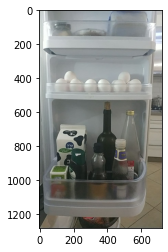

In [ ]:
import matplotlib.pyplot as plt

img = Image.open("download.jpg") 
img = img.convert("RGB")
milk = np.array(img)
plt.imshow(milk)

In [ ]:
milk.shape

(720, 1280, 3)

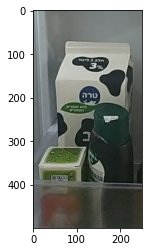

In [ ]:
plt.imshow(milk[600:1100, 50:300])

In [ ]:
milk = np.array([milk[600:1100, 50:300]])

In [ ]:
milk.shape

(1, 500, 250, 3)

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(wandb.restore("model-best.h5", run_path="/zshoham/FridgeVision/vwjigbmr").name)
best_model.trainable = False
model = tf.keras.Model(best_model.input, best_model.output, name="Best")
model.summary()

Model: "Best"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                32025  

In [ ]:

probs = model.predict(milk)
print(probs)
print(np.argmax(probs, axis=1))

[[9.8163468e-01 7.3412363e-03 2.1092632e-05 9.8012367e-07 4.0505675e-04
  1.2116152e-07 4.5598161e-05 1.7905360e-04 1.6180836e-04 4.3613531e-06
  5.9270893e-05 5.2584743e-04 8.7633714e-05 3.2550929e-08 2.3265410e-04
  1.8578225e-04 1.1322107e-03 7.9365661e-03 2.4387020e-05 2.7806623e-06
  7.0261885e-06 4.7515373e-06 4.1887160e-06 2.0881428e-06 7.7455604e-07]]
[0]


In [ ]:
cls_map["id-name"][0]

'Milk'

In [ ]:
cls_map["name-id"]['Pepper']

8

In [ ]:
probs[0][8]

0.17623538